# décrire le problème [TO DO]

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch.autograd import grad

In [18]:
class ActivationCube(torch.nn.Module):
    def __init__(self) -> None:
        super(ActivationCube, self).__init__()

    def forward(self, x):
        return torch.maximum(x**3, torch.tensor(0.))

class RitzModel(torch.nn.Module):

    def __init__(self):
        super(RitzModel, self).__init__()

        self.fc1 = torch.nn.Linear(in_features=1, out_features=10)
        self.activation1 = ActivationCube()
        self.fc2 = torch.nn.Linear(in_features=10, out_features=10)
        self.activation2 = ActivationCube()

        self.fc3 = torch.nn.Linear(in_features=10, out_features=10)
        self.activation3 = ActivationCube()
        self.fc4 = torch.nn.Linear(in_features=10, out_features=10)
        self.activation4 = ActivationCube()

        self.fc5 = torch.nn.Linear(in_features=10, out_features=10)
        self.activation5 = ActivationCube()
        self.fc6 = torch.nn.Linear(in_features=10, out_features=10)
        self.activation6 = ActivationCube()

        self.fc7 = torch.nn.Linear(in_features=10, out_features=10)
        self.activation7 = ActivationCube()
        self.fc8 = torch.nn.Linear(in_features=10, out_features=10)
        self.activation8 = ActivationCube()

        self.fc9 = torch.nn.Linear(in_features=10, out_features=1)

        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, mean=0, std=0.1)

    def forward(self, x):
        retain_x1 = x
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = x + retain_x1

        retain_x2 = x
        x = self.fc3(x)
        x = self.activation3(x)
        x = self.fc4(x)
        x = self.activation4(x)
        x = x + retain_x2

        retain_x3 = x
        x = self.fc5(x)
        x = self.activation5(x)
        x = self.fc6(x)
        x = self.activation6(x)
        x = x + retain_x3

        retain_x4 = x
        x = self.fc7(x)
        x = self.activation7(x)
        x = self.fc8(x)
        x = self.activation8(x)
        x = x + retain_x4

        u_theta = self.fc9(x)

        return u_theta

In [3]:
def u_true(x):
    return np.sin(x)**2

def f_true(x):
    return np.sin(2*x) + 2*x*np.cos(2*x)

In [9]:
vxn  = 50
vx =np.linspace(0, np.pi, vxn) 
ix = torch.FloatTensor(vx).reshape(vxn,1)

torch.Size([1, 1, 50]) torch.Size([50, 1])


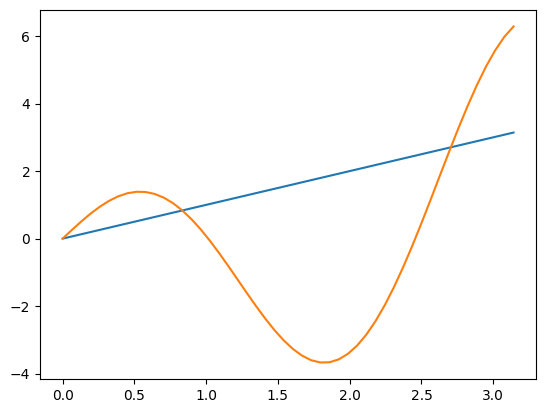

In [13]:
plt.plot(ix, ix)
plt.plot(ix, f_true(ix))

In [184]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.il  = torch.nn.Linear(1,80)
        self.mi  = torch.nn.Linear(80,80)
        self.mi1  = torch.nn.Linear(80,80)
        self.mi2 = torch.nn.Linear(80,40)
        self.ol  = torch.nn.Linear(40,1)

        self.tn  = torch.nn.Tanh()
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, mean=0, std=0.1)

    def forward(self,x):
        u = x
        hidden1 = self.il(u)
        hidden2 = self.mi(self.tn(hidden1))
        hidden2a = self.mi1(self.tn(hidden2))
        hidden3 = self.mi2(self.tn(hidden2a))
        out =  self.ol(self.tn(hidden3))
        return out

In [183]:
boundary = torch.FloatTensor([vx[0], vx[-1]]).reshape(2,1)
true_boundary = torch.FloatTensor([0., 0.]).reshape(2,1) # homogeneous boundary condition

pred_boundary_ritz = np.array([])
pred_boundary_net = np.array([])

ritz_model = RitzModel()
net_model = Net()

for _ in range(100) :
    pred_boundary_ritz = np.append(pred_boundary_ritz, ritz_model(boundary).detach().numpy())
    pred_boundary_net = np.append(pred_boundary_net, net_model(boundary).detach().numpy())

print(np.mean(pred_boundary_ritz), np.mean(pred_boundary_net))

-0.2591366171836853 -0.2982456386089325


In [169]:
def flat(x):
    m = x.shape[0]
    return [x[i] for i in range(m)]

def Du(x, model):
    u = model(x)
    u_x = grad(flat(u), x, create_graph=True, allow_unused=True)[0]
    z = u_x*x
    u_xx = grad(flat(z), x, create_graph=True, allow_unused=True)[0]
    return u_xx

In [170]:
import random

nb_batch = 20
batches_list = []
f_batches_list = []

for _ in range(nb_batch) :
    batch = np.array(random.choices(vx, k=10))
    batch = torch.FloatTensor(batch).reshape(10,1)
    batch.requires_grad = True
    batches_list.append(batch)

    f_batch = torch.FloatTensor(f_true(batch.detach().numpy())).reshape(10,1)
    f_batch.requires_grad = True
    f_batches_list.append(f_batch)

print(Du(batches_list[0], net_model))

tensor([[0.0179],
        [0.0189],
        [0.0159],
        [0.0187],
        [0.0155],
        [0.0174],
        [0.0159],
        [0.0182],
        [0.0186],
        [0.0086]], grad_fn=<AddBackward0>)


In [190]:
net_model = RitzModel()
epochs = 1000
loss_fn = torch.nn.MSELoss()
optimizer_f = torch.optim.Adam(net_model.parameters(), lr=0.0005)
optimizer_boundary = torch.optim.Adam(net_model.parameters(), lr=0.001)

for epoch in range(epochs) :
    for _ in range(nb_batch) :
        batch_index = np.random.randint(0, nb_batch)
        batch = batches_list[batch_index]
        f_batch = f_batches_list[batch_index]

        optimizer_f.zero_grad()
        optimizer_boundary.zero_grad()

        output_boundary = net_model(boundary)
        output_f = Du(batch, net_model)

        loss_boundary = loss_fn(output_boundary, true_boundary)
        loss_f = loss_fn(output_f, f_batch)

        loss_f.backward(retain_graph=True)
        loss_boundary.backward(retain_graph=True)
        optimizer_f.step()
        optimizer_boundary.step()

    if epoch % 10 == 0 :
        print(f'Epoch {epoch} : Loss boundary {loss_boundary.item()} Loss f {loss_f.item()}')

Epoch 0 : Loss boundary 2.4186816215515137 Loss f 3.954714298248291
Epoch 10 : Loss boundary 2.1648285388946533 Loss f 2.85798716545105
Epoch 20 : Loss boundary 2.01810359954834 Loss f 7.566279411315918
Epoch 30 : Loss boundary 1.8653854131698608 Loss f 5.335675239562988
Epoch 40 : Loss boundary 1.748368263244629 Loss f 2.1330726146698
Epoch 50 : Loss boundary 1.5885180234909058 Loss f 6.398343086242676
Epoch 60 : Loss boundary 1.4196854829788208 Loss f 1.470811128616333
Epoch 70 : Loss boundary 1.1572725772857666 Loss f 3.9477367401123047
Epoch 80 : Loss boundary 0.9425098896026611 Loss f 3.1745476722717285
Epoch 90 : Loss boundary 0.6799024343490601 Loss f 0.8818656802177429
Epoch 100 : Loss boundary 0.45850056409835815 Loss f 2.4621901512145996
Epoch 110 : Loss boundary 0.38572728633880615 Loss f 0.6795274019241333
Epoch 120 : Loss boundary 0.2750023603439331 Loss f 2.7601726055145264
Epoch 130 : Loss boundary 0.20224489271640778 Loss f 0.37793585658073425
Epoch 140 : Loss boundary 

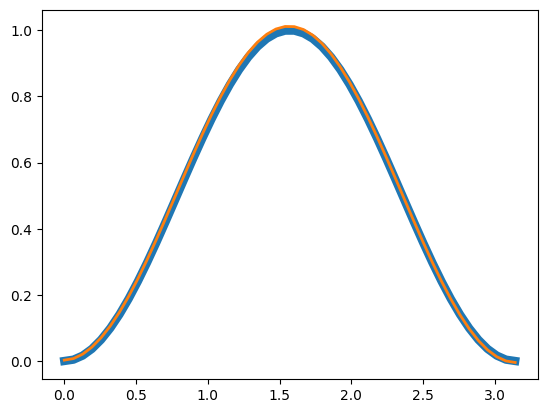

In [191]:
ix = torch.FloatTensor(vx).reshape(vxn,1)
u = net_model(ix)
plt.plot(ix, u_true(ix) ,  linewidth=6)
plt.plot(ix, u.detach().numpy(), linewidth=2)